# Muon neutrino interactions SND

We will read a file with neutrino and antineutrinos, already selected into the target (hits have been wrongly written, to be fixed)

In [1]:
import uproot
import awkward #need for flatten or other operations to nested arrays
import numpy as np
import matplotlib.pyplot as plt #for plots

In [2]:
import ROOT as r


Welcome to JupyROOT 6.24/06


Let us write the functions to read cbmsim branches with uproot

In [3]:
def access_track_branches(simtree, prefix="MCTrack.f", entry_start=0, entry_stop = -1):
 '''reading MCTracks from entry_start to lastentry'''
 if (entry_stop < 0):
        lastentry = simtree.num_entries
 else:
        lastentry = entry_stop
 #what branches do we want to read
 suffixes = ["MotherId","PdgCode","StartX","StartY","StartZ","Px","Py","Pz"]
 branchnames = [prefix + suff for suff in suffixes]
 print(branchnames)
 #reading the branches
 tracks = simtree.arrays(branchnames,entry_start = entry_start, entry_stop = lastentry)
 #returning the produced array
 return tracks

In [4]:
def access_mcpoint_branches(simtree, prefix = "ScifiPoint.f", entry_start=0, entry_stop = -1 ):
 '''reading MCTracks from entry_start to lastentry'''
 if (entry_stop < 0):
        lastentry = simtree.num_entries
 else:
        lastentry = entry_stop   

 suffixes = ["PdgCode","TrackID","X","Y","Z","Px","Py","Pz"]
 branchnames = [prefix + suff for suff in suffixes]
 print(branchnames)
 #reading the branches
 mcpoints = simtree.arrays(branchnames[0:2],entry_start = entry_start, entry_stop = lastentry)
 #adding float interpretation manually
 floatinterpretation = simtree["MCTrack.fStartX"].interpretation
 for name in branchnames[2:]:
  mcpoints[name] = simtree[name].array(floatinterpretation)
 #returning the produced array
 return mcpoints

Let us open the file and getting the TTree

In [5]:
numufile = uproot.open("/eos/user/a/aiulian/sim_snd/numu_sim_activeemu_7_September_2021/inECC_sndLHC.Genie-TGeant4.root")
numutree = numufile["cbmsim"]

In [6]:
antimufile = uproot.open("/eos/user/a/aiulian/sim_snd/anumu_sim_activeemu_8_September_2021/inECC_sndLHC.Genie-TGeant4.root")
antimutree = antimufile["cbmsim"]

## Get track information
Let us retrieve the tracks branch from both files and concatenate them

In [7]:
numutracks = access_track_branches(numutree)
antimu_tracks = access_track_branches(antimutree)
tracks = awkward.concatenate([antimu_tracks,numutracks])

['MCTrack.fMotherId', 'MCTrack.fPdgCode', 'MCTrack.fStartX', 'MCTrack.fStartY', 'MCTrack.fStartZ', 'MCTrack.fPx', 'MCTrack.fPy', 'MCTrack.fPz']
['MCTrack.fMotherId', 'MCTrack.fPdgCode', 'MCTrack.fStartX', 'MCTrack.fStartY', 'MCTrack.fStartZ', 'MCTrack.fPx', 'MCTrack.fPy', 'MCTrack.fPz']


Let us retrieve the tracks coming from the neutrino

In [8]:
neutrinodaughters = tracks["MCTrack.fMotherId"]==0

How do I access track charge?

In [9]:
pdgdatabase = r.TDatabasePDG.Instance()
def getcharge(pdgcode):
    charge = 0
    if (pdgdatabase.GetParticle(pdgcode)): #not all particles are known
        charge = pdgdatabase.GetParticle(pdgcode).Charge()
    return charge

In [10]:
trackpdgs = tracks["MCTrack.fPdgCode"]
nevents = len(trackpdgs)

## Addition of charge
for the moment we do it the old fashioned loop way: slow, to be "vectorized in some way"

In [11]:
trackcharge = []
#looping over the events
for event in range(nevents):
    trackchargeevent = []
    #looping over the tracks
    for pdgcode in trackpdgs[event]:
        trackchargeevent.append(getcharge(pdgcode))
    trackcharge.append(trackchargeevent)
awtrackcharge = awkward.Array(trackcharge)
#adding track branch
tracks["MCTrack.fCharge"] = awtrackcharge

## Identification of neutrino daughters

In [12]:
neutrinodaughters = np.logical_and(tracks["MCTrack.fMotherId"]==0,np.abs(tracks["MCTrack.fCharge"]) > 0)
neutrinodaughters_pdgs = trackpdgs[neutrinodaughters]

In [13]:
molteplicity = []
for event in range(nevents):
    molteplicity.append(len(neutrinodaughters_pdgs[event]))

## Plots

we start with the molteplicity plot

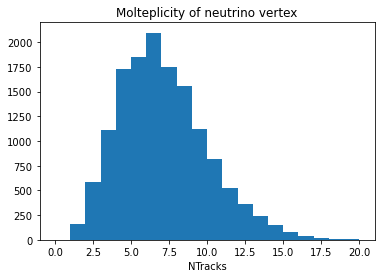

In [14]:
%matplotlib inline
plt.figure()
plt.hist(molteplicity,bins=20,range=[0,20])
plt.xlabel("NTracks")
plt.title("Molteplicity of neutrino vertex")
plt.show()

Neutrino and muon energy plots

In [15]:
tracks["MCTrack.fP"] = np.sqrt(tracks["MCTrack.fPx"] * tracks["MCTrack.fPx"] + tracks["MCTrack.fPy"] * tracks["MCTrack.fPy"] + tracks["MCTrack.fPz"] * tracks["MCTrack.fPz"])

Who is the muon neutrino?

In [16]:
numutracks["MCTrack.fPx"][:,0]

<Array [-0.224, -0.0564, ... -0.0876, -0.0158] type='7405 * float64'>

Who is the primary muon? PdgCode 13 and MotherId 0

In [17]:
primarymuon = np.logical_and(tracks["MCTrack.fMotherId"]==0,np.abs(tracks["MCTrack.fPdgCode"]) == 13)
primarymuon_P = tracks["MCTrack.fP"][primarymuon]

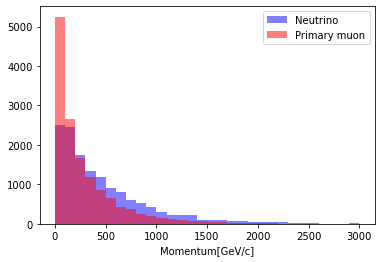

In [18]:
plt.figure()
plt.hist(tracks["MCTrack.fP"][:,0],bins=30,range=[0,3000],color="b",label="Neutrino",alpha=0.5)
plt.hist(awkward.flatten(primarymuon_P),bins=30,range=[0,3000],color="r",label="Primary muon",alpha=0.5)
plt.xlabel("Momentum[GeV/c]")
plt.legend()
plt.show()

In **which brick** did the interation happen?

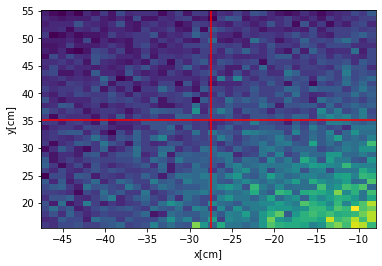

In [19]:
plt.figure()
plt.hist2d(awkward.to_numpy(tracks["MCTrack.fStartX"][:,0]),awkward.to_numpy(tracks["MCTrack.fStartY"][:,0]),bins=[40,40],range=[[-47.6 , -8.0 ],[15.5 , 55.1 ]])
plt.xlabel("x[cm]")
plt.ylabel("y[cm]")
plt.plot([-27.5,-27.5],[15,55],"r")
plt.plot([-50,-5],[35.1,35.1],"r")
plt.show()

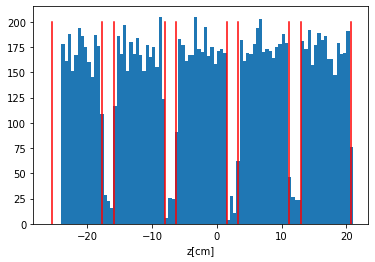

In [20]:
plt.figure()
plt.hist(awkward.to_numpy(tracks["MCTrack.fStartZ"][:,0]),bins=94,range=[-26.,21.])
plt.xlabel("z[cm]")

#adding lines
plt.plot([-25.4750 , -25.4750],[0,200],"r")
plt.plot([-17.6850 , -17.6850],[0,200],"r")

plt.plot([ -15.8750 ,-15.8750],[0,200],"r")
plt.plot([-8.0850,-8.0850],[0,200],"r")

plt.plot([-6.2750  ,-6.2750],[0,200],"r")
plt.plot([1.5150  ,1.5150],[0,200],"r")

plt.plot([3.3250   ,3.3250],[0,200],"r")
plt.plot([11.1150  ,11.1150],[0,200],"r")

plt.plot([12.9250,12.9250],[0,200],"r")
plt.plot([20.7150,20.7150],[0,200],"r")

plt.show()

In [21]:
len(neutrinodaughters_pdgs[245])

1

In [22]:
whichbrick[245]

NameError: name 'whichbrick' is not defined

What is the momentum of neutrino charged daughters?

In [ ]:
tracks["MCTrack.fP"] = (tracks["MCTrack.fPx"]**2 +  tracks["MCTrack.fPy"]**2 +  tracks["MCTrack.fPz"]**2)**0.5

In [ ]:
neutrinodaughters_P = tracks["MCTrack.fP"][neutrinodaughters]

In [ ]:
plt.figure()
plt.hist(awkward.to_numpy(awkward.flatten(neutrinodaughters_P)),bins=100,range=[0,100])
plt.xlabel("P[GeV/c]")
plt.show()